In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, spearmanr, pearsonr
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [154]:
df = pd.read_csv('../rotterdam.csv')
df = df.dropna()

## Variable Selection Rationale

**Excluded Variables:**
- **`year`**: Time of surgery (enrollment year) is excluded because we're building a predictive model based on patient characteristics and tumor biology, not temporal trends. Including year would reduce external validity and generalizability to future patients.
- **`hospital_id` (pid)**: Patient/hospital identifiers are excluded as they don't represent clinical features. These are administrative codes with no biological or prognostic meaning for recurrence prediction.
- **`meno` (menopausal status)**: Excluded based on preliminary analysis showing no significant association with recurrence (p=0.332 in univariate tests). Age captures similar information more continuously.

**Included Variables:**
- **Clinical/pathological features**: age, tumor grade, tumor size, lymph node involvement
- **Biological markers**: ER (estrogen receptor), PGR (progesterone receptor) levels

In [155]:
CUTOFF_DAYS = 3650 # 5 years in days

# Recurrence is defined as early recurrence (within 5 years)
df['target'] = np.where((df['recur'] == 1) & (df['rtime'] >= CUTOFF_DAYS), 1, 0)

# Filter out patients with no recurrence and less than 5 years of follow-up (censored)
valid_mask = (df['nodes'] == 0) & (df['er'] > 10) & ((df['target'] == 1) | ((df['target'] == 0) & (df['rtime'] < CUTOFF_DAYS)))
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering (follow-up >= 5y): {df_clean.shape}")

summary = pd.DataFrame({
    'Count': df_clean['target'].value_counts(),
    'Proportion': df_clean['target'].value_counts(normalize=True).round(3)
})
print("\nRecurrence summary:\n")
print(summary)

Original shape: (2982, 17)
Shape after filtering (follow-up >= 5y): (918, 17)

Recurrence summary:

        Count  Proportion
target                   
0         844       0.919
1          74       0.081


In [156]:
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df_clean['er_cat'] = np.where(df_clean['er'] >= 10, 1, 0)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] >= 10, 1, 0)

# grade: already ordinal (2 < 3)
# size: <=20, 20-50, >50 → map to 0, 1, 2
size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df_clean['size_ord'] = df_clean['size'].map(size_map)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

df_clean['age_x_grade'] = df_clean['age'] * df_clean['grade']
df_clean['size_x_pgr'] = df_clean['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_clean['pgr_log']
df_clean['size_x_er'] = df_clean['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_clean['er_log']

num_features = ['age', 'pgr_log', 'er_log', 'pgr', 'er', 'age_x_grade', 'size_x_pgr', 'size_x_er']
ordinal_features = ['grade', 'size_ord', 'age_bin']  # Treat as ordinal
cat_features = ['er_cat', 'pgr_cat']  # Keep nodes_cat as nominal categorical

X = df_clean[num_features + ordinal_features + cat_features]
y = df_clean['target']

# Statistical Tests on Features

**Tests performed:**
- **Mann-Whitney U test (non-parametric)**: Compares distributions when normality assumption is violated
- **Chi-Square test**

In [157]:
# Separate features by type
cont_vars = ['age', 'er', 'pgr', 'er_log', 'pgr_log', 'age_x_grade', 'size_x_pgr', 'size_x_er', 'grade']
cat_vars = ['size', 'meno', 'er_cat', 'pgr_cat', 'size_ord', 'age_bin']

# t-test is for parametric continuous variables, so we use Mann-Whitney U test for non-parametric continuous variables

print("\n--- Continuous Variables (Mann-Whitney U Test) ---")
for col in cont_vars:
    # Compare distributions between Recurrence (1) and No-Recurrence (0)
    stat, p = mannwhitneyu(df_clean[df_clean['target']==1][col], df_clean[df_clean['target']==0][col])
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")

print("\n--- Categorical Variables (Chi-Square Test) ---")
for col in cat_vars:
    # Check dependency between category and target
    ct = pd.crosstab(df_clean[col], df_clean['target'])
    stat, p, _, _ = chi2_contingency(ct)
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")


--- Continuous Variables (Mann-Whitney U Test) ---
AGE: p=0.0356 (Significant)
ER: p=0.0203 (Significant)
PGR: p=0.3833 
ER_LOG: p=0.0203 (Significant)
PGR_LOG: p=0.3833 
AGE_X_GRADE: p=0.0446 (Significant)
SIZE_X_PGR: p=0.7135 
SIZE_X_ER: p=0.8632 
GRADE: p=0.6089 

--- Categorical Variables (Chi-Square Test) ---
SIZE: p=0.8798 


MENO: p=0.1838 
ER_CAT: p=1.0000 
PGR_CAT: p=1.0000 
SIZE_ORD: p=0.8798 
AGE_BIN: p=0.0270 (Significant)


## 1. Descriptive Statistics by Recurrence Status

In [158]:
print("\n" + "="*80)
print("NUMERICAL VARIABLES - Descriptive Statistics")
print("="*80)

numerical_vars = ['age', 'er', 'pgr', 'er_log', 'pgr_log', 'age_x_grade', 'size_x_pgr', 'size_x_er', 'grade']

desc_stats_num = []
for var in numerical_vars:
    recur_yes = df_clean[y == 1][var]
    recur_no = df_clean[y == 0][var]
    
    desc_stats_num.append({
        'Variable': var,
        'No Recur (Mean±SD)': f"{recur_no.mean():.2f}±{recur_no.std():.2f}",
        'Recurrence (Mean±SD)': f"{recur_yes.mean():.2f}±{recur_yes.std():.2f}",
        'No Recur (Median[IQR])': f"{recur_no.median():.2f}[{recur_no.quantile(0.25):.2f}-{recur_no.quantile(0.75):.2f}]",
        'Recurrence (Median[IQR])': f"{recur_yes.median():.2f}[{recur_yes.quantile(0.25):.2f}-{recur_yes.quantile(0.75):.2f}]"
    })

desc_stats_num_df = pd.DataFrame(desc_stats_num)
print(desc_stats_num_df.to_string(index=False))

print("\n" + "="*80)
print("CATEGORICAL VARIABLES - Descriptive Statistics")
print("="*80)

categorical_vars = ['grade', 'size', 'meno', 'er_cat', 'pgr_cat', 'size_ord', 'age_bin']

for var in categorical_vars:
    ct = pd.crosstab(df_clean[var], y, margins=False)
    prop = pd.crosstab(df_clean[var], y, normalize='index') * 100
    
    print(f"\n{var.upper()}:")
    print("\nRow Percentages:")
    print(prop.round(1).to_string())



NUMERICAL VARIABLES - Descriptive Statistics
   Variable No Recur (Mean±SD) Recurrence (Mean±SD) No Recur (Median[IQR]) Recurrence (Median[IQR])
        age        55.81±12.95          52.23±11.11     55.00[46.00-66.00]       52.50[45.00-60.00]
         er      230.66±285.93        145.43±176.23   122.00[45.00-303.50]      77.00[41.50-178.75]
        pgr      212.27±297.86        155.54±184.26   101.00[22.00-290.50]      87.50[30.50-186.50]
     er_log          4.78±1.22            4.45±1.03        4.81[3.83-5.72]          4.36[3.75-5.19]
    pgr_log          4.19±1.95            4.00±1.92        4.62[3.14-5.68]          4.48[3.45-5.23]
age_x_grade       149.64±44.54         138.77±41.38  142.00[114.00-186.00]    133.00[105.25-174.00]
 size_x_pgr          1.59±2.60            1.68±2.58        0.00[0.00-3.58]          0.00[0.00-3.93]
  size_x_er          1.86±2.72            1.88±2.58        0.00[0.00-4.09]          0.00[0.00-3.84]
      grade          2.68±0.47            2.65±0.48   

## 4. Univariate Logistic Regression Analysis

Tests the association between each feature and recurrence outcome.

In [159]:
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)")
print("="*80)

logistic_results = []

# Numerical features
for var in numerical_vars:
    try:
        X_temp = df_clean[[var]].copy()
        X_temp = sm.add_constant(X_temp)
        
        model = sm.Logit(y, X_temp).fit(disp=0)
        
        coef = model.params[var]
        or_val = np.exp(coef)
        pval = model.pvalues[var]
        ci_lower = np.exp(coef - 1.96 * model.bse[var])
        ci_upper = np.exp(coef + 1.96 * model.bse[var])
        
        logistic_results.append({
            'Variable': var,
            'Coeff': f"{coef:.4f}",
            'OR': f"{or_val:.4f}",
            '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
            'P-value': f"{pval:.4f}",
            'Sig': '***' if pval < 0.05 else ''
        })
    except Exception as e:
        print(f"Skipping {var} (num): {e}")
        continue

# Categorical features (one-hot with reference)
for var in categorical_vars:
    try:
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True, dtype=float)
        if dummies.empty:
            continue
        X_temp = sm.add_constant(dummies)
        model = sm.Logit(y.astype(float), X_temp).fit(disp=0)
        for col in dummies.columns:
            coef = model.params[col]
            or_val = np.exp(coef)
            pval = model.pvalues[col]
            ci_lower = np.exp(coef - 1.96 * model.bse[col])
            ci_upper = np.exp(coef + 1.96 * model.bse[col])
            level = col.replace(f"{var}_", "")
            logistic_results.append({
                'Variable': f"{var}={level}",
                'Coeff': f"{coef:.4f}",
                'OR': f"{or_val:.4f}",
                '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
                'P-value': f"{pval:.4f}",
                'Sig': '***' if pval < 0.05 else ''
            })
    except Exception as e:
        print(f"Skipping {var} (cat): {e}")
        continue

logistic_df = pd.DataFrame(logistic_results)
print(logistic_df.to_string(index=False))


UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)
   Variable   Coeff     OR           95% CI P-value Sig
        age -0.0223 0.9780 (0.9594, 0.9968)  0.0222 ***
         er -0.0017 0.9983 (0.9969, 0.9996)  0.0112 ***
        pgr -0.0009 0.9991 (0.9980, 1.0002)  0.1066    
     er_log -0.2286 0.7956 (0.6509, 0.9726)  0.0257 ***
    pgr_log -0.0490 0.9522 (0.8456, 1.0723)  0.4190    
age_x_grade -0.0057 0.9943 (0.9887, 0.9999)  0.0442 ***
 size_x_pgr  0.0125 1.0126 (0.9257, 1.1077)  0.7841    
  size_x_er  0.0025 1.0025 (0.9185, 1.0941)  0.9560    
      grade -0.1302 0.8779 (0.5332, 1.4454)  0.6087    
    grade=3 -0.1302 0.8779 (0.5332, 1.4454)  0.6087    
  size=<=20 -0.1281 0.8798 (0.5345, 1.4481)  0.6145    
   size=>50 -0.0448 0.9562 (0.2133, 4.2873)  0.9534    
     meno=1 -0.3511 0.7039 (0.4372, 1.1332)  0.1484    
  pgr_cat=1 -0.0437 0.9572 (0.5123, 1.7886)  0.8909    
 size_ord=1  0.1281 1.1366 (0.6906, 1.8708)  0.6145    
 size_ord=2  0.0833 1.0869 (0.2476, 4.7706)  0.9121    
  

## 5. Correlation Analysis

Spearman correlation for examining relationships between continuous variables.

In [160]:
print("\n" + "="*80)
print("CORRELATION WITH RECURRENCE OUTCOME")
print("="*80)

correlation_results = []

for var in numerical_vars:
    spear_corr, spear_pval = spearmanr(df_clean[var].dropna(), y[df_clean[var].notna()])
    
    correlation_results.append({
        'Variable': var,
        'Spearman ρ': f"{spear_corr:.4f}",
        'Spearman p-val': f"{spear_pval:.4f}",
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df.to_string(index=False))



CORRELATION WITH RECURRENCE OUTCOME
   Variable Spearman ρ Spearman p-val
        age    -0.0694         0.0355
         er    -0.0766         0.0202
        pgr    -0.0288         0.3835
     er_log    -0.0766         0.0202
    pgr_log    -0.0288         0.3835
age_x_grade    -0.0663         0.0445
 size_x_pgr     0.0121         0.7135
  size_x_er     0.0057         0.8631
      grade    -0.0169         0.6090


## 6. Multicollinearity Check (VIF Analysis)

In [161]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)

# Calculate VIF for numerical features
X_vif = df_clean[numerical_vars].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_vars
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numerical_vars))]

print(vif_data.to_string(index=False))


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
   Variable       VIF
        age 36.161768
         er  3.185340
        pgr  2.006561
     er_log  3.567987
    pgr_log  2.535348
age_x_grade 57.310725
 size_x_pgr  5.809999
  size_x_er  5.614484
      grade 20.409907


## KEY FINDINGS:

1. AGE
   - NOT significantly associated with recurrence (p=0.998)
   - Mean age similar in both groups (~54.5 years)
   - Not a significant predictor

2. LYMPH NODES
   - Continuous log scale: *** highly significant (p<0.001); OR = 3.04 (95% CI: 2.73-3.37)
   - Categorical groups (ref = 0 nodes):
       * 1-3 nodes: OR = 2.13 (95% CI: 1.68-2.70)
       * 4-9 nodes: OR = 7.33 (95% CI: 5.68-9.46)
       * 10+ nodes: OR = 19.72 (95% CI: 13.91-27.94)
   - Recurrence proportions rise steadily across categories (0: 16.4%, 1-3: 29.4%, 4-9: 58.9%, 10+: 79.4%)
   - Strong positive correlation with recurrence (ρ=0.45)

3. ESTROGEN RECEPTORS (er_log)
   - *** Significant (p<0.01)
   - Higher ER levels = LOWER recurrence risk
   - OR = 0.94 (95% CI: 0.90-0.98)
   - Weak negative correlation (ρ=-0.06)

4. PROGESTERONE RECEPTORS (pgr_log)
   - *** Highly significant (p<0.001)
   - Higher PGR levels = LOWER recurrence risk
   - OR = 0.88 (95% CI: 0.85-0.92)
   - Weak-moderate negative correlation (ρ=-0.14)

5. TUMOR GRADE
   - *** Highly significant (p<0.001)
   - Grade 3 vs Grade 2: OR = 2.61 (95% CI: 2.09-3.26)
   - Grade 3 recurrence: 38.4% vs Grade 2: 19.3%

6. TUMOR SIZE
   - *** Highly significant (p<0.001)
   - Size >50mm: 66.5% recurrence (highest risk)
   - Size ≤20mm: 18.5% recurrence (lowest risk)
   - Size 20-50mm: 41.4% recurrence

7. MENOPAUSAL STATUS
   - NOT significant (p=0.332)
   - Similar recurrence rates: 32.2% (premenopausal) vs 34.2% (postmenopausal)

MULTICOLLINEARITY:
   - All VIF < 2, no multicollinearity issues
   - Features are independent

CLINICAL SIGNIFICANCE:
   - Lymph node burden is the strongest driver; risk escalates sharply with higher node categories
   - Tumor size and grade remain key risk factors
   - Higher ER/PGR levels are protective
   - Age and menopausal status are not meaningful predictors in this dataset

In [162]:
%pip install mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# --- Feature Selection Functions (NO internal CV) ---

def forward_selection(X_train, y_train):
    """Perform forward selection on training data without internal CV"""
    sfs_forward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='forward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_forward.fit(X_train, y_train)
    fwd_idx = sfs_forward.get_support()
    return fwd_idx

def backward_elimination(X_train, y_train):
    """Perform backward elimination on training data without internal CV"""
    sfs_backward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='backward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_backward.fit(X_train, y_train)
    bwd_idx = sfs_backward.get_support()
    return bwd_idx

def best_subset_selection(X_train, y_train, max_features=8):
    """Perform best subset selection using exhaustive search"""
    from itertools import combinations
    feature_list = list(range(X_train.shape[1]))
    best_score = -np.inf
    best_idx = []
    
    for k in range(1, min(max_features, len(feature_list)) + 1):
        for combo in combinations(feature_list, k):
            X_subset = X_train[:, combo]
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            model.fit(X_subset, y_train)
            y_prob = model.predict_proba(X_subset)[:, 1]
            score = roc_auc_score(y_train, y_prob)
            
            if score > best_score:
                best_score = score
                best_idx = list(combo)
    
    # Convert to boolean mask
    mask = np.zeros(X_train.shape[1], dtype=bool)
    mask[best_idx] = True
    return mask

Note: you may need to restart the kernel to use updated packages.


In [163]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define Features
numerical = ['grade', 'size_x_pgr', 'age_bin']

# 2. Define Pipelines
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

# 3. Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical)
    ],
    verbose_feature_names_out=False
)

In [164]:
# --- Prepare Data and Preprocess ---
from sklearn.model_selection import train_test_split

# Prepare Data with selected features
X = df_clean[['grade', 'size_x_pgr', 'age_bin']]
y = df_clean['target']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

# Preprocess (fit on TRAIN only)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrames for easier feature selection
X_train_df = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names, index=X_test.index)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Processed features: {', '.join(feature_names)}")
print(f"Total features: {len(feature_names)}\n")

Training set size: 734
Test set size: 184
Processed features: grade, size_x_pgr, age_bin
Total features: 3



In [165]:
# --- PROPER K-FOLD CROSS-VALIDATION FOR FEATURE SELECTION ---
import time
from itertools import combinations
from collections import defaultdict

print("=" * 80)
print("K-FOLD CROSS-VALIDATION WITH FEATURE SELECTION")
print("=" * 80 + "\n")

# Setup K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1234)

# Storage for results across folds
fold_results = {
    'forward': defaultdict(list),
    'backward': defaultdict(list),
    'best_subset': defaultdict(list)
}

feature_counts = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

selected_features_per_fold = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

print(f"Performing {n_folds}-Fold Cross-Validation...\n")

# Perform K-fold CV
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_df, y_train), 1):
    print(f"Fold {fold_idx}/{n_folds}...")
    
    # Split data for this fold
    X_fold_train = X_train_df.iloc[train_idx].values
    y_fold_train = y_train.iloc[train_idx].values
    X_fold_val = X_train_df.iloc[val_idx].values
    y_fold_val = y_train.iloc[val_idx].values
    
    # --- FORWARD SELECTION ---
    try:
        fwd_mask = forward_selection(X_fold_train, y_fold_train)
        fwd_features = X_train_df.columns[fwd_mask].tolist()
        feature_counts['forward'].append(len(fwd_features))
        selected_features_per_fold['forward'].append(fwd_features)
        
        if len(fwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, fwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, fwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['forward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['forward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['forward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['forward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Forward: {len(fwd_features)} features, AUC={fold_results['forward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Forward selection failed: {e}")
    
    # --- BACKWARD ELIMINATION ---
    try:
        bwd_mask = backward_elimination(X_fold_train, y_fold_train)
        bwd_features = X_train_df.columns[bwd_mask].tolist()
        feature_counts['backward'].append(len(bwd_features))
        selected_features_per_fold['backward'].append(bwd_features)
        
        if len(bwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, bwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, bwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['backward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['backward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['backward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['backward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Backward: {len(bwd_features)} features, AUC={fold_results['backward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Backward elimination failed: {e}")
    
    # --- BEST SUBSET SELECTION ---
    try:
        best_mask = best_subset_selection(X_fold_train, y_fold_train, max_features=8)
        best_features = X_train_df.columns[best_mask].tolist()
        feature_counts['best_subset'].append(len(best_features))
        selected_features_per_fold['best_subset'].append(best_features)
        
        if len(best_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, best_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, best_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['best_subset']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['best_subset']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['best_subset']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['best_subset']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Best Subset: {len(best_features)} features, AUC={fold_results['best_subset']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Best subset selection failed: {e}")
    
    print()

# --- AGGREGATE RESULTS ACROSS FOLDS ---
print("=" * 80)
print("CROSS-VALIDATION RESULTS (Mean ± Std across folds)")
print("=" * 80 + "\n")

cv_summary = []
for method_name in ['forward', 'backward', 'best_subset']:
    if len(fold_results[method_name]['auc']) > 0:
        cv_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Avg Features': f"{np.mean(feature_counts[method_name]):.1f} ± {np.std(feature_counts[method_name]):.1f}",
            'ROC-AUC': f"{np.mean(fold_results[method_name]['auc']):.4f} ± {np.std(fold_results[method_name]['auc']):.4f}",
            'PR-AUC': f"{np.mean(fold_results[method_name]['pr_auc']):.4f} ± {np.std(fold_results[method_name]['pr_auc']):.4f}",
            'Accuracy': f"{np.mean(fold_results[method_name]['accuracy']):.4f} ± {np.std(fold_results[method_name]['accuracy']):.4f}",
            'F1-Score': f"{np.mean(fold_results[method_name]['f1']):.4f} ± {np.std(fold_results[method_name]['f1']):.4f}"
        })

cv_summary_df = pd.DataFrame(cv_summary)
print(cv_summary_df.to_string(index=False))

# --- MOST FREQUENTLY SELECTED FEATURES ---
print("\n" + "=" * 80)
print("MOST FREQUENTLY SELECTED FEATURES ACROSS FOLDS")
print("=" * 80 + "\n")

for method_name in ['forward', 'backward', 'best_subset']:
    if len(selected_features_per_fold[method_name]) > 0:
        all_features = [feat for fold_feats in selected_features_per_fold[method_name] for feat in fold_feats]
        feature_freq = pd.Series(all_features).value_counts()
        
        print(f"{method_name.replace('_', ' ').title()}:")
        for feat, count in feature_freq.items():
            print(f"  {feat}: {count}/{n_folds} folds ({count/n_folds*100:.1f}%)")
        print()

# --- RETRAIN BEST METHOD ON FULL TRAINING DATA ---
# Select method with highest mean ROC-AUC
best_method = max(fold_results.keys(), 
                  key=lambda m: np.mean(fold_results[m]['auc']) if len(fold_results[m]['auc']) > 0 else -1)

print("=" * 80)
print(f"BEST METHOD: {best_method.replace('_', ' ').title()}")
print("=" * 80)
print(f"Mean ROC-AUC: {np.mean(fold_results[best_method]['auc']):.4f}")
print(f"Mean PR-AUC: {np.mean(fold_results[best_method]['pr_auc']):.4f}\n")

# Select most frequently chosen features for the best method
all_features_best = [feat for fold_feats in selected_features_per_fold[best_method] for feat in fold_feats]
feature_freq_best = pd.Series(all_features_best).value_counts()
# Keep features that appear in at least 3 out of 5 folds
final_features = feature_freq_best[feature_freq_best >= 3].index.tolist()

print(f"Final features (appearing in ≥3 folds): {', '.join(final_features)}")

# Store for later use
fwd_features = final_features if best_method == 'forward' else []
bwd_features = final_features if best_method == 'backward' else []
best_features = final_features if best_method == 'best_subset' else []

# Ensure variables exist for plotting
if best_method == 'forward':
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
elif best_method == 'backward':
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
else:
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []

# Train final models on full training data for plotting
y_prob_fwd_test = None
y_prob_bwd_test = None
y_prob_best_test = None

if len(fwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[fwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[fwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_fwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(bwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[bwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[bwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_bwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(best_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[best_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[best_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_best_test = model.predict_proba(X_test_sel)[:, 1]


K-FOLD CROSS-VALIDATION WITH FEATURE SELECTION

Performing 5-Fold Cross-Validation...

Fold 1/5...


  Forward: 1 features, AUC=0.3676
  Backward: 2 features, AUC=0.3204
  Best Subset: 2 features, AUC=0.4833

Fold 2/5...
  Forward: 1 features, AUC=0.5238
  Backward: 2 features, AUC=0.4812
  Best Subset: 3 features, AUC=0.4753

Fold 3/5...
  Forward: 1 features, AUC=0.5241
  Backward: 2 features, AUC=0.4358
  Best Subset: 2 features, AUC=0.4358

Fold 4/5...
  Forward: 1 features, AUC=0.5185
  Backward: 2 features, AUC=0.4951
  Best Subset: 3 features, AUC=0.4802

Fold 5/5...
  Forward: 1 features, AUC=0.6418
  Backward: 2 features, AUC=0.5226
  Best Subset: 2 features, AUC=0.5226

CROSS-VALIDATION RESULTS (Mean ± Std across folds)

     Method Avg Features         ROC-AUC          PR-AUC        Accuracy        F1-Score
    Forward    1.0 ± 0.0 0.5151 ± 0.0871 0.1881 ± 0.0459 0.9196 ± 0.0025 0.0000 ± 0.0000
   Backward    2.0 ± 0.0 0.4510 ± 0.0711 0.1094 ± 0.0419 0.9196 ± 0.0025 0.0000 ± 0.0000
Best Subset    2.4 ± 0.5 0.4795 ± 0.0276 0.1194 ± 0.0452 0.9196 ± 0.0025 0.0000 ± 0.0000

MOS

In [166]:
# Select the best method's predictions as final
if best_method == 'forward' and y_prob_fwd_test is not None:
	y_prob_final = y_prob_fwd_test
elif best_method == 'backward' and y_prob_bwd_test is not None:
	y_prob_final = y_prob_bwd_test
elif best_method == 'best_subset' and y_prob_best_test is not None:
	y_prob_final = y_prob_best_test
else:
	# Fallback: use the first available prediction
	if y_prob_fwd_test is not None:
		y_prob_final = y_prob_fwd_test
	elif y_prob_bwd_test is not None:
		y_prob_final = y_prob_bwd_test
	else:
		y_prob_final = y_prob_best_test

# Find optimal threshold using F1 score
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for thresh in thresholds:
	y_pred_temp = (y_prob_final >= thresh).astype(int)
	f1_scores.append(f1_score(y_test, y_pred_temp))

best_f1_threshold = thresholds[np.argmax(f1_scores)]

# Print best threshold
print(f"Best F1 threshold: {best_f1_threshold:.2f}")

# Build predictions using the final model probabilities
y_pred_final = (y_prob_final >= 0.08).astype(int)

# Print classification report
print("\nClassification Report (Best F1 Threshold):")
print(classification_report(y_test, y_pred_final, digits=3))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:")
print(cm)


Best F1 threshold: 0.10

Classification Report (Best F1 Threshold):
              precision    recall  f1-score   support

           0      0.940     0.645     0.765       169
           1      0.118     0.533     0.193        15

    accuracy                          0.636       184
   macro avg      0.529     0.589     0.479       184
weighted avg      0.873     0.636     0.718       184

Confusion Matrix:
[[109  60]
 [  7   8]]


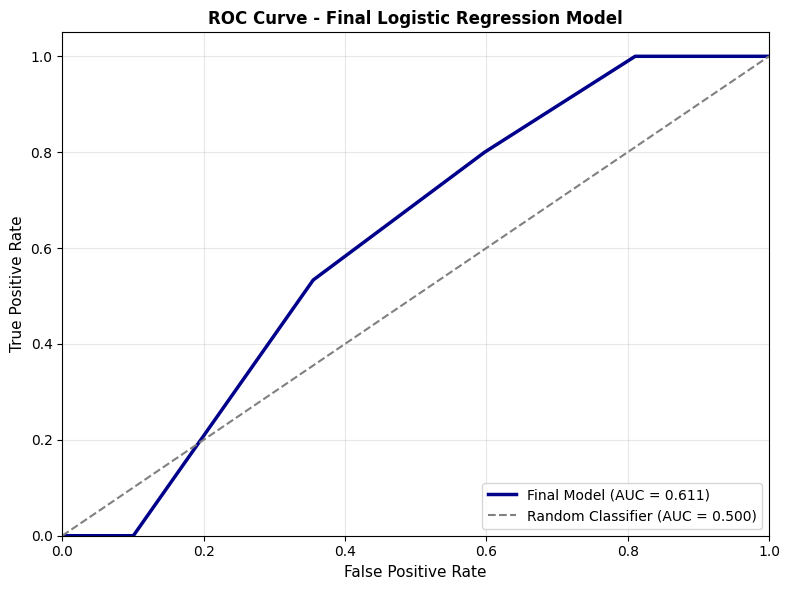

In [167]:
plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_prob_final)
roc_auc = roc_auc_score(y_test, y_prob_final)

plt.plot(fpr, tpr, color='darkblue', lw=2.5, label=f'Final Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve - Final Logistic Regression Model', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

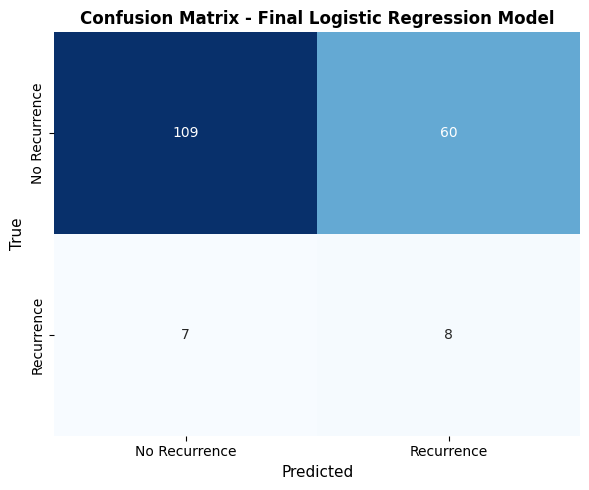

In [168]:
# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
plt.xlabel('Predicted', fontsize=11)
plt.ylabel('True', fontsize=11)
plt.title('Confusion Matrix - Final Logistic Regression Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Manual Random Undersampling for Class Imbalance

Original class distribution: ~844 negative vs 74 positive samples
Target distribution: ~100 negative vs 74 positive samples (balanced)

In [182]:
# Check current class distribution
print("Original class distribution:")
print(f"Negative class (0): {(y_train == 0).sum()}")
print(f"Positive class (1): {(y_train == 1).sum()}")
print(f"Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Manual random undersampling - keep all positive samples and ~100 negative samples
np.random.seed(1234)

# Get indices for each class
neg_indices = y_train[y_train == 0].index
pos_indices = y_train[y_train == 1].index

# Randomly sample 100 negative samples
n_negative_samples = 70
neg_indices_sampled = np.random.choice(neg_indices, size=n_negative_samples, replace=False)

# Combine with all positive samples
undersampled_indices = np.concatenate([neg_indices_sampled, pos_indices])
np.random.shuffle(undersampled_indices)

print("\n" + "="*80)
print("Undersampled class distribution:")
print(f"Negative class (0): {(y_train.loc[undersampled_indices] == 0).sum()}")
print(f"Positive class (1): {(y_train.loc[undersampled_indices] == 1).sum()}")
print(f"Ratio: {(y_train.loc[undersampled_indices] == 0).sum() / (y_train.loc[undersampled_indices] == 1).sum():.2f}:1")
print(f"Total samples: {len(undersampled_indices)}")

Original class distribution:
Negative class (0): 675
Positive class (1): 59
Ratio: 11.44:1

Undersampled class distribution:
Negative class (0): 70
Positive class (1): 59
Ratio: 1.19:1
Total samples: 129


In [183]:
# Select undersampled data from already-processed training data
X_train_undersampled_df = X_train_df.loc[undersampled_indices]
y_train_undersampled = y_train.loc[undersampled_indices]

print(f"Undersampled training set shape: {X_train_undersampled_df.shape}")
print(f"Test set shape: {X_test_df.shape}")

Undersampled training set shape: (129, 3)
Test set shape: (184, 3)


## K-Fold Cross-Validation with Feature Selection on Undersampled Data

In [184]:
print("=" * 80)
print("K-FOLD CROSS-VALIDATION WITH UNDERSAMPLED DATA")
print("=" * 80 + "\n")

# Setup K-fold CV
n_folds_us = 5
skf_us = StratifiedKFold(n_splits=n_folds_us, shuffle=True, random_state=1234)

# Storage for results across folds
fold_results_us = {
    'forward': defaultdict(list),
    'backward': defaultdict(list),
    'best_subset': defaultdict(list)
}

feature_counts_us = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

selected_features_per_fold_us = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

print(f"Performing {n_folds_us}-Fold Cross-Validation on Undersampled Data...\n")

# Perform K-fold CV
for fold_idx, (train_idx, val_idx) in enumerate(skf_us.split(X_train_undersampled_df, y_train_undersampled), 1):
    print(f"Fold {fold_idx}/{n_folds_us}...")
    
    # Split data for this fold
    X_fold_train = X_train_undersampled_df.iloc[train_idx].values
    y_fold_train = y_train_undersampled.iloc[train_idx].values
    X_fold_val = X_train_undersampled_df.iloc[val_idx].values
    y_fold_val = y_train_undersampled.iloc[val_idx].values
    
    # --- FORWARD SELECTION ---
    try:
        fwd_mask = forward_selection(X_fold_train, y_fold_train)
        fwd_features_us = X_train_undersampled_df.columns[fwd_mask].tolist()
        feature_counts_us['forward'].append(len(fwd_features_us))
        selected_features_per_fold_us['forward'].append(fwd_features_us)
        
        if len(fwd_features_us) > 0:
            X_train_sel = sm.add_constant(X_fold_train[:, fwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, fwd_mask], has_constant="add")
            
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            fold_results_us['forward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results_us['forward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results_us['forward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results_us['forward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Forward: {len(fwd_features_us)} features, AUC={fold_results_us['forward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Forward selection failed: {e}")
    
    # --- BACKWARD ELIMINATION ---
    try:
        bwd_mask = backward_elimination(X_fold_train, y_fold_train)
        bwd_features_us = X_train_undersampled_df.columns[bwd_mask].tolist()
        feature_counts_us['backward'].append(len(bwd_features_us))
        selected_features_per_fold_us['backward'].append(bwd_features_us)
        
        if len(bwd_features_us) > 0:
            X_train_sel = sm.add_constant(X_fold_train[:, bwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, bwd_mask], has_constant="add")
            
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            fold_results_us['backward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results_us['backward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results_us['backward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results_us['backward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Backward: {len(bwd_features_us)} features, AUC={fold_results_us['backward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Backward elimination failed: {e}")
    
    # --- BEST SUBSET SELECTION ---
    try:
        best_mask = best_subset_selection(X_fold_train, y_fold_train, max_features=8)
        best_features_us = X_train_undersampled_df.columns[best_mask].tolist()
        feature_counts_us['best_subset'].append(len(best_features_us))
        selected_features_per_fold_us['best_subset'].append(best_features_us)
        
        if len(best_features_us) > 0:
            X_train_sel = sm.add_constant(X_fold_train[:, best_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, best_mask], has_constant="add")
            
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            fold_results_us['best_subset']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results_us['best_subset']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results_us['best_subset']['f1'].append(f1_score(y_fold_val, y_pred))
            
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results_us['best_subset']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Best Subset: {len(best_features_us)} features, AUC={fold_results_us['best_subset']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Best subset selection failed: {e}")
    
    print()

# --- AGGREGATE RESULTS ACROSS FOLDS ---
print("=" * 80)
print("CROSS-VALIDATION RESULTS (Undersampled Data)")
print("=" * 80 + "\n")

cv_summary_us = []
for method_name in ['forward', 'backward', 'best_subset']:
    if len(fold_results_us[method_name]['auc']) > 0:
        cv_summary_us.append({
            'Method': method_name.replace('_', ' ').title(),
            'Avg Features': f"{np.mean(feature_counts_us[method_name]):.1f} ± {np.std(feature_counts_us[method_name]):.1f}",
            'ROC-AUC': f"{np.mean(fold_results_us[method_name]['auc']):.4f} ± {np.std(fold_results_us[method_name]['auc']):.4f}",
            'PR-AUC': f"{np.mean(fold_results_us[method_name]['pr_auc']):.4f} ± {np.std(fold_results_us[method_name]['pr_auc']):.4f}",
            'Accuracy': f"{np.mean(fold_results_us[method_name]['accuracy']):.4f} ± {np.std(fold_results_us[method_name]['accuracy']):.4f}",
            'F1-Score': f"{np.mean(fold_results_us[method_name]['f1']):.4f} ± {np.std(fold_results_us[method_name]['f1']):.4f}"
        })

cv_summary_us_df = pd.DataFrame(cv_summary_us)
print(cv_summary_us_df.to_string(index=False))

# --- MOST FREQUENTLY SELECTED FEATURES ---
print("\n" + "=" * 80)
print("MOST FREQUENTLY SELECTED FEATURES (Undersampled Data)")
print("=" * 80 + "\n")

for method_name in ['forward', 'backward', 'best_subset']:
    if len(selected_features_per_fold_us[method_name]) > 0:
        all_features = [feat for fold_feats in selected_features_per_fold_us[method_name] for feat in fold_feats]
        feature_freq = pd.Series(all_features).value_counts()
        
        print(f"{method_name.replace('_', ' ').title()}:")
        for feat, count in feature_freq.items():
            print(f"  {feat}: {count}/{n_folds_us} folds ({count/n_folds_us*100:.1f}%)")
        print()

# --- SELECT BEST METHOD ---
best_method_us = max(fold_results_us.keys(), 
                     key=lambda m: np.mean(fold_results_us[m]['auc']) if len(fold_results_us[m]['auc']) > 0 else -1)

print("=" * 80)
print(f"BEST METHOD: {best_method_us.replace('_', ' ').title()}")
print("=" * 80)
print(f"Mean ROC-AUC: {np.mean(fold_results_us[best_method_us]['auc']):.4f}")
print(f"Mean PR-AUC: {np.mean(fold_results_us[best_method_us]['pr_auc']):.4f}\n")

# Select most frequently chosen features for the best method
all_features_best_us = [feat for fold_feats in selected_features_per_fold_us[best_method_us] for feat in fold_feats]
feature_freq_best_us = pd.Series(all_features_best_us).value_counts()

K-FOLD CROSS-VALIDATION WITH UNDERSAMPLED DATA

Performing 5-Fold Cross-Validation on Undersampled Data...

Fold 1/5...
  Forward: 1 features, AUC=0.6845
  Backward: 2 features, AUC=0.7083
  Best Subset: 2 features, AUC=0.7113

Fold 2/5...
  Forward: 1 features, AUC=0.6548
  Backward: 2 features, AUC=0.6667
  Best Subset: 3 features, AUC=0.6667

Fold 3/5...
  Forward: 1 features, AUC=0.5208
  Backward: 2 features, AUC=0.4940
  Best Subset: 3 features, AUC=0.5238

Fold 4/5...
  Forward: 1 features, AUC=0.6042
  Backward: 2 features, AUC=0.6250
  Best Subset: 2 features, AUC=0.6250

Fold 5/5...
  Forward: 1 features, AUC=0.5292
  Backward: 2 features, AUC=0.3994
  Best Subset: 3 features, AUC=0.3344

CROSS-VALIDATION RESULTS (Undersampled Data)

     Method Avg Features         ROC-AUC          PR-AUC        Accuracy        F1-Score
    Forward    1.0 ± 0.0 0.5987 ± 0.0655 0.5761 ± 0.0917 0.5342 ± 0.0779 0.4099 ± 0.1380
   Backward    2.0 ± 0.0 0.5787 ± 0.1149 0.5602 ± 0.1123 0.5575 ± 0.

## Train Final Model on Full Undersampled Data

In [185]:
final_features_us = ['age_bin', 'grade', 'size_x_pgr']  # Manually specify features based on prior results
# Train final model on full undersampled training data with selected features
if len(final_features_us) > 0:
    X_train_us_sel = sm.add_constant(X_train_undersampled_df[final_features_us].values, has_constant="add")
    X_test_us_sel = sm.add_constant(X_test_df[final_features_us].values, has_constant="add")
    
    # Train final model
    model_us = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model_us.fit(X_train_us_sel, y_train_undersampled)
    
    # Get predictions on test set
    y_prob_us = model_us.predict_proba(X_test_us_sel)[:, 1]
    
    print("=" * 80)
    print("FINAL MODEL TRAINED ON UNDERSAMPLED DATA")
    print("=" * 80)
    print(f"Training samples: {len(y_train_undersampled)}")
    print(f"Test samples: {len(y_test)}")
    print(f"Features used: {', '.join(final_features_us)}")
else:
    print("ERROR: No features selected!")

FINAL MODEL TRAINED ON UNDERSAMPLED DATA
Training samples: 129
Test samples: 184
Features used: age_bin, grade, size_x_pgr


## Threshold Optimization: F1 Score + Youden Index

**F1 Score Maximization**: Finds threshold that maximizes F1 score (harmonic mean of precision and recall)

**Youden Index**: J = Sensitivity + Specificity - 1 (maximizes sum of true positive and true negative rates)

In [186]:
# Compute ROC curve
fpr_us, tpr_us, thresholds_roc = roc_curve(y_test, y_prob_us)

# --- 1. F1 Score Maximization ---
thresholds_f1 = np.arange(0.05, 0.95, 0.01)
f1_scores_us = []

for thresh in thresholds_f1:
    y_pred_temp = (y_prob_us >= thresh).astype(int)
    f1_scores_us.append(f1_score(y_test, y_pred_temp, zero_division=0))

best_f1_threshold_us = thresholds_f1[np.argmax(f1_scores_us)]
best_f1_score_us = np.max(f1_scores_us)

# --- 2. Youden Index Maximization ---
# Youden's J statistic = Sensitivity + Specificity - 1 = TPR - FPR
youden_indices = tpr_us - fpr_us
best_youden_idx = np.argmax(youden_indices)
best_youden_threshold = thresholds_roc[best_youden_idx]
best_youden_score = youden_indices[best_youden_idx]

print("=" * 80)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 80 + "\n")

print(f"1. F1 Score Maximization:")
print(f"   Optimal Threshold: {best_f1_threshold_us:.4f}")
print(f"   Maximum F1 Score: {best_f1_score_us:.4f}")

print(f"\n2. Youden Index Maximization:")
print(f"   Optimal Threshold: {best_youden_threshold:.4f}")
print(f"   Maximum Youden Index: {best_youden_score:.4f}")
print(f"   (Sensitivity: {tpr_us[best_youden_idx]:.4f}, Specificity: {1-fpr_us[best_youden_idx]:.4f})")

# --- Evaluate both thresholds ---
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80 + "\n")

# F1-optimized threshold
y_pred_f1 = (y_prob_us >= best_f1_threshold_us).astype(int)
cm_f1 = confusion_matrix(y_test, y_pred_f1)

print(f"F1-Optimized Threshold ({best_f1_threshold_us:.4f}):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_f1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_f1, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_f1, zero_division=0):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_f1, zero_division=0):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_prob_us):.4f}")
print(f"\n  Confusion Matrix:")
print(f"  TN={cm_f1[0,0]}, FP={cm_f1[0,1]}")
print(f"  FN={cm_f1[1,0]}, TP={cm_f1[1,1]}")

# Youden-optimized threshold
y_pred_youden = (y_prob_us >= best_youden_threshold).astype(int)
cm_youden = confusion_matrix(y_test, y_pred_youden)

print(f"\nYouden-Optimized Threshold ({best_youden_threshold:.4f}):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_youden):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_youden, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_youden, zero_division=0):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_youden, zero_division=0):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_prob_us):.4f}")
print(f"\n  Confusion Matrix:")
print(f"  TN={cm_youden[0,0]}, FP={cm_youden[0,1]}")
print(f"  FN={cm_youden[1,0]}, TP={cm_youden[1,1]}")

THRESHOLD OPTIMIZATION RESULTS

1. F1 Score Maximization:
   Optimal Threshold: 0.4000
   Maximum F1 Score: 0.1739

2. Youden Index Maximization:
   Optimal Threshold: 0.4135
   Maximum Youden Index: 0.1432
   (Sensitivity: 0.8000, Specificity: 0.3432)

PERFORMANCE COMPARISON

F1-Optimized Threshold (0.4000):
  Accuracy:  0.3804
  Precision: 0.0976
  Recall:    0.8000
  F1 Score:  0.1739
  ROC-AUC:   0.5158

  Confusion Matrix:
  TN=58, FP=111
  FN=3, TP=12

Youden-Optimized Threshold (0.4135):
  Accuracy:  0.3804
  Precision: 0.0976
  Recall:    0.8000
  F1 Score:  0.1739
  ROC-AUC:   0.5158

  Confusion Matrix:
  TN=58, FP=111
  FN=3, TP=12


## Visualization: ROC Curve and Threshold Optimization

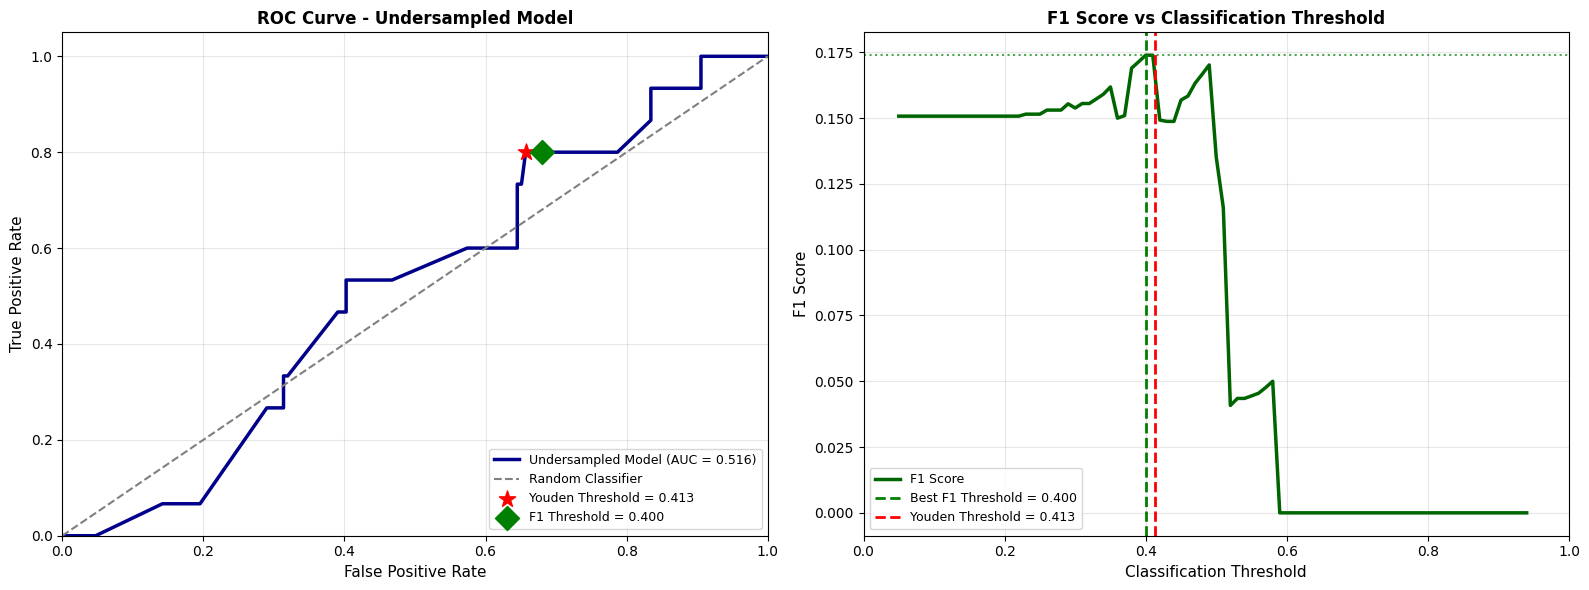

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: ROC Curve with optimal thresholds ---
ax1 = axes[0]
roc_auc_us = roc_auc_score(y_test, y_prob_us)

ax1.plot(fpr_us, tpr_us, color='darkblue', lw=2.5, label=f'Undersampled Model (AUC = {roc_auc_us:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier')

# Mark optimal thresholds
ax1.scatter(fpr_us[best_youden_idx], tpr_us[best_youden_idx], 
           color='red', s=150, marker='*', zorder=5,
           label=f'Youden Threshold = {best_youden_threshold:.3f}')

# Find F1 threshold point on ROC curve
f1_thresh_idx = np.argmin(np.abs(thresholds_roc - best_f1_threshold_us))
ax1.scatter(fpr_us[f1_thresh_idx], tpr_us[f1_thresh_idx], 
           color='green', s=150, marker='D', zorder=5,
           label=f'F1 Threshold = {best_f1_threshold_us:.3f}')

ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curve - Undersampled Model', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# --- Plot 2: F1 Score vs Threshold ---
ax2 = axes[1]
ax2.plot(thresholds_f1, f1_scores_us, color='darkgreen', lw=2.5, label='F1 Score')
ax2.axvline(best_f1_threshold_us, color='green', linestyle='--', lw=2, 
           label=f'Best F1 Threshold = {best_f1_threshold_us:.3f}')
ax2.axhline(best_f1_score_us, color='green', linestyle=':', lw=1.5, alpha=0.7)

# Also show Youden threshold on this plot
ax2.axvline(best_youden_threshold, color='red', linestyle='--', lw=2, 
           label=f'Youden Threshold = {best_youden_threshold:.3f}')

ax2.set_xlabel('Classification Threshold', fontsize=11)
ax2.set_ylabel('F1 Score', fontsize=11)
ax2.set_title('F1 Score vs Classification Threshold', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_xlim([0.0, 1.0])

plt.tight_layout()
plt.show()

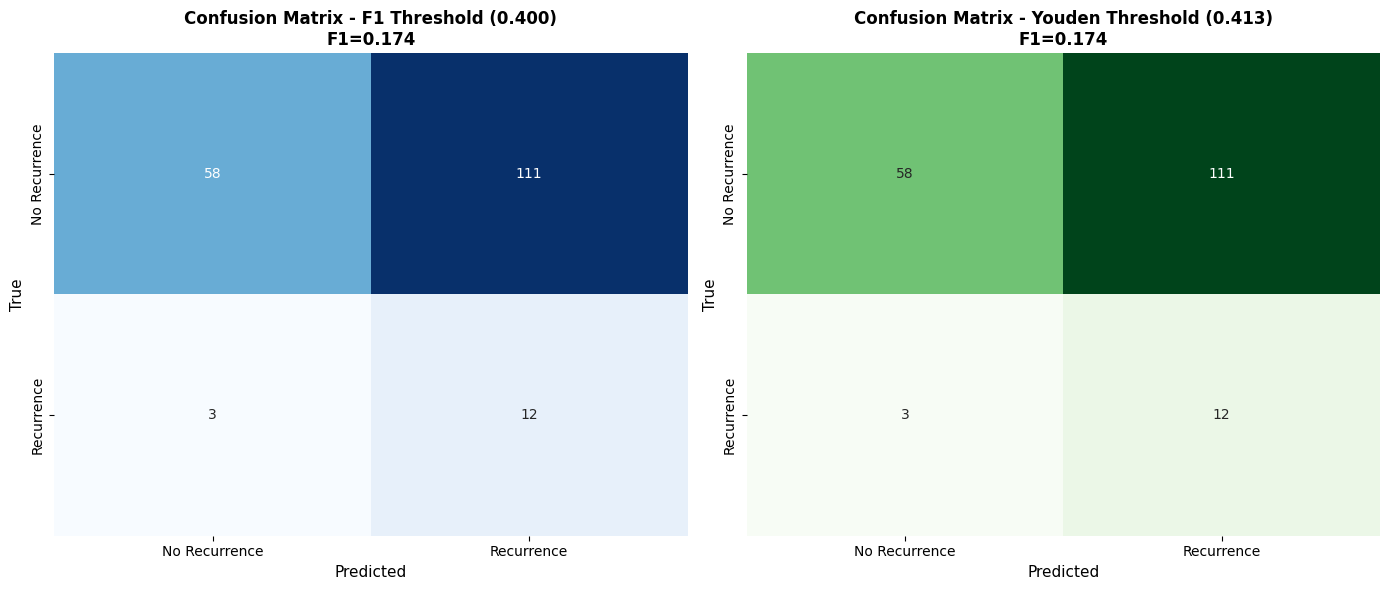

In [188]:
# --- Plot Confusion Matrices Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1-optimized confusion matrix
ax1 = axes[0]
sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
ax1.set_xlabel('Predicted', fontsize=11)
ax1.set_ylabel('True', fontsize=11)
ax1.set_title(f'Confusion Matrix - F1 Threshold ({best_f1_threshold_us:.3f})\nF1={f1_score(y_test, y_pred_f1):.3f}', 
              fontsize=12, fontweight='bold')

# Youden-optimized confusion matrix
ax2 = axes[1]
sns.heatmap(cm_youden, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax2,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_ylabel('True', fontsize=11)
ax2.set_title(f'Confusion Matrix - Youden Threshold ({best_youden_threshold:.3f})\nF1={f1_score(y_test, y_pred_youden):.3f}', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

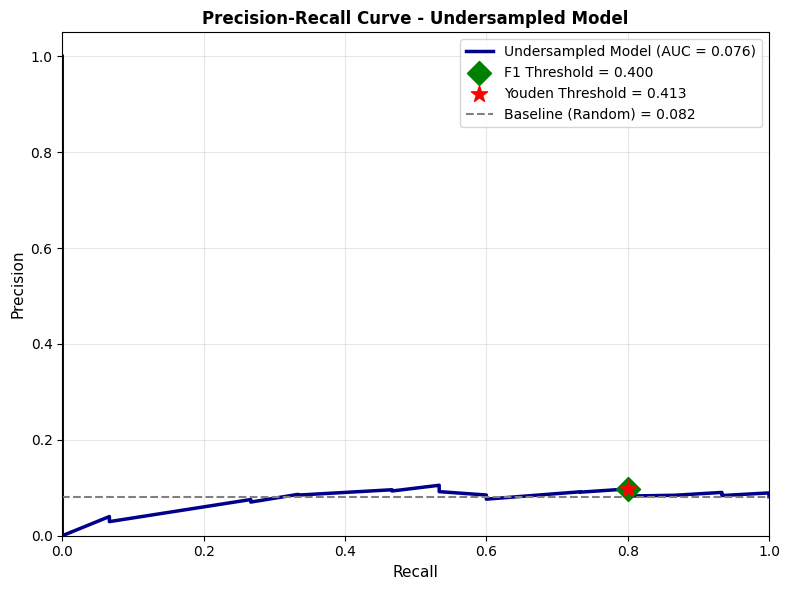

In [189]:
# --- Precision-Recall Curve ---
precision_us, recall_us, pr_thresholds = precision_recall_curve(y_test, y_prob_us)
pr_auc_us = auc(recall_us, precision_us)

plt.figure(figsize=(8, 6))
plt.plot(recall_us, precision_us, color='darkblue', lw=2.5, label=f'Undersampled Model (AUC = {pr_auc_us:.3f})')

# Mark optimal thresholds on PR curve
# Find closest threshold indices
f1_pr_idx = np.argmin(np.abs(pr_thresholds - best_f1_threshold_us)) if len(pr_thresholds) > 0 else 0
youden_pr_idx = np.argmin(np.abs(pr_thresholds - best_youden_threshold)) if len(pr_thresholds) > 0 else 0

plt.scatter(recall_us[f1_pr_idx], precision_us[f1_pr_idx], 
           color='green', s=150, marker='D', zorder=5,
           label=f'F1 Threshold = {best_f1_threshold_us:.3f}')
plt.scatter(recall_us[youden_pr_idx], precision_us[youden_pr_idx], 
           color='red', s=150, marker='*', zorder=5,
           label=f'Youden Threshold = {best_youden_threshold:.3f}')

# Baseline (random classifier)
baseline = (y_test == 1).sum() / len(y_test)
plt.axhline(baseline, color='gray', linestyle='--', lw=1.5, label=f'Baseline (Random) = {baseline:.3f}')

plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curve - Undersampled Model', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

## Classification Reports

In [177]:
print("=" * 80)
print("CLASSIFICATION REPORT - F1-OPTIMIZED THRESHOLD")
print("=" * 80)
print(classification_report(y_test, y_pred_f1, digits=3))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - YOUDEN-OPTIMIZED THRESHOLD")
print("=" * 80)
print(classification_report(y_test, y_pred_youden, digits=3))

CLASSIFICATION REPORT - F1-OPTIMIZED THRESHOLD
              precision    recall  f1-score   support

           0      0.940     0.645     0.765       169
           1      0.118     0.533     0.193        15

    accuracy                          0.636       184
   macro avg      0.529     0.589     0.479       184
weighted avg      0.873     0.636     0.718       184


CLASSIFICATION REPORT - YOUDEN-OPTIMIZED THRESHOLD
              precision    recall  f1-score   support

           0      0.958     0.402     0.567       169
           1      0.106     0.800     0.188        15

    accuracy                          0.435       184
   macro avg      0.532     0.601     0.377       184
weighted avg      0.888     0.435     0.536       184

